In [50]:
%matplotlib inline
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage, misc
from scipy.linalg import toeplitz
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [51]:
### Set up problem
# parameters
t0 = -5
tn = 99.5
ts = 12.0
n  = int(2*(tn-t0)+1)
t  = np.linspace(-5,99.5,n)
dt = 0.5
g0 = 1

# Define G
idx = int(np.argwhere(t==ts))
G = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if (i >= j):
            G[i,j] = g0*(t[i]-t[j])*np.exp(-(t[i]-t[j])/ts)*dt


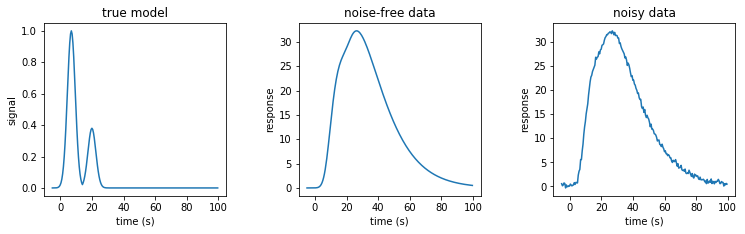

In [52]:
### Part a
# Make a true model that looks like the one in fig. 4.4
mt1 = norm.pdf(t, 7, 2.5)
mt1 = mt1/max(mt1)
mt1 = mt1[0:38]
mt2 = norm.pdf(t, 20, 2.5)
mt2 = (mt2/max(mt2))*.38
mt2 = mt2[38:]
mt  = np.concatenate([mt1, mt2]) 

# Generate noise-free
dnf    = np.dot(G,mt)

# Generate noisy data s.t. sigma=1% of peak measurement
np.random.seed(0)
dmax  = max(dnf)*0.01
dn    = dnf+np.random.normal(0.0,dmax,n)

# plot
ax=plt.subplot(131)
plt.subplots_adjust(left=0.4, bottom=0.4, right=2, top=1.0, hspace=0.4, wspace=0.4)
plt.plot(t,mt)
plt.title('true model')
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")

ax=plt.subplot(132)
plt.plot(t,dnf)
ax.set_xlabel("time (s)")
ax.set_ylabel("response")
plt.title('noise-free data')

ax=plt.subplot(133)
plt.plot(t,dn)
ax.set_xlabel("time (s)")
ax.set_ylabel("response")
plt.title('noisy data')

plt.show()

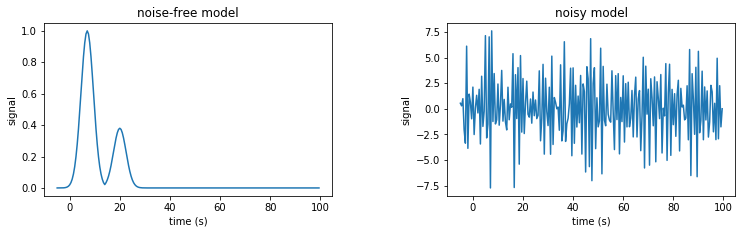

In [53]:
### Part b
# SVD 
[u, s, v] = np.linalg.svd(G)
v  = v.T
p  = np.linalg.matrix_rank(G)
up = u[:, 0:p]
vp = v[:, 0:p]
sp = s[0:p]

sm = np.eye(p,p)
for i in range(p):
    sm[i,i] = sp[i]
smi = np.linalg.inv(sm)

# Recover noise-free and noisy data
Gt        = np.dot(np.dot(vp,smi), up.T)
mest_nf   = np.dot(Gt, dnf)
mest_n    = np.dot(Gt, dn)

# plot
ax=plt.subplot(121)
plt.subplots_adjust(left=0.4, bottom=0.4, right=2, top=1.0, hspace=0.4, wspace=0.4)
plt.plot(t,mest_nf)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
plt.title('noise-free model')

ax=plt.subplot(122)
plt.plot(t,mest_n)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
plt.title('noisy model')
plt.show()

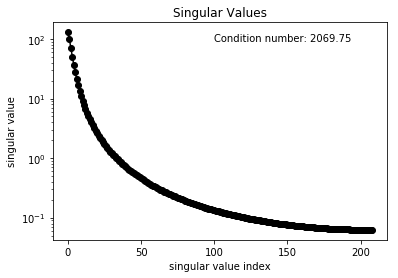

In [54]:
### Part c
# condition number
Cmp = sp[0]/sp[-1]
cmps = str(Cmp)
# Plot singular values
ax=plt.subplot(111)
xa = np.arange(s.shape[0]-1)
plt.semilogy(xa, sp, 'ok', xa, sp, 'k')
ax.set_xlabel("singular value index")
ax.set_ylabel("singular value")
plt.title('Singular Values')
plt.annotate('Condition number: '+cmps[0:-9],(100,90))
plt.show()

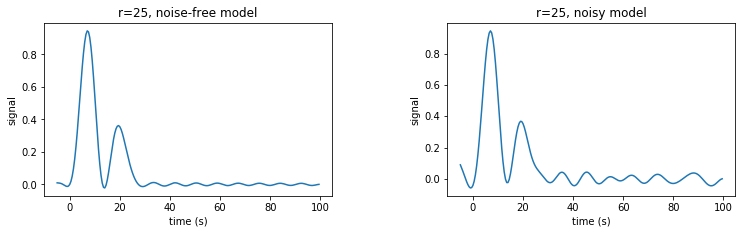

In [55]:
### Part d
# SVD with only 25 largest SVs 
r = 25
ur = u[:, 0:r]
vr = v[:, 0:r]
sr = s[0:r]

srm = np.eye(r,r)
for i in range(r):
    srm[i,i] = sr[i]
srmi = np.linalg.inv(srm)

Gt_r        = np.dot(np.dot(vr,srmi), ur.T)
mest_nf_r   = np.dot(Gt_r, dnf)
mest_n_r    = np.dot(Gt_r, dn)

# plot
ax=plt.subplot(121)
plt.subplots_adjust(left=0.4, bottom=0.4, right=2, top=1.0, hspace=0.4, wspace=0.4)
plt.plot(t,mest_nf_r)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
plt.title('r=25, noise-free model')

ax=plt.subplot(122)
plt.plot(t,mest_n_r)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
plt.title('r=25, noisy model')
plt.show()

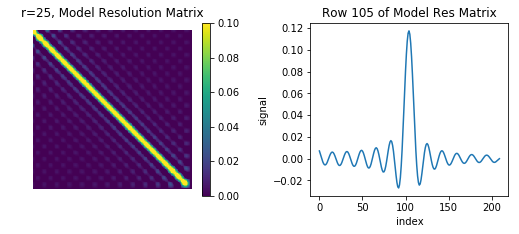

In [56]:
### Part e
# model resolution matrix (Gsvd*G)
Rm    = np.flipud(np.dot(Gt_r,G))
row   = int(n/2)
xsec  = Rm[row,:]
xxsec = np.arange(s.shape[0])

# plot
ax=plt.subplot(121)
plt.subplots_adjust(left=0.4, bottom=0.4, right=1.5, top=1.0, hspace=0.4, wspace=0.4)
plt.pcolor(Rm, vmin=0, vmax=.1)
plt.axis('off')
plt.axis('equal')
plt.title('r=25, Model Resolution Matrix')
plt.colorbar()

ax=plt.subplot(122)
plt.plot(xxsec,xsec)
ax.set_xlabel("index")
ax.set_ylabel("signal")
plt.title('Row '+str(row)+' of Model Res Matrix')
plt.show()


plt.show()


100


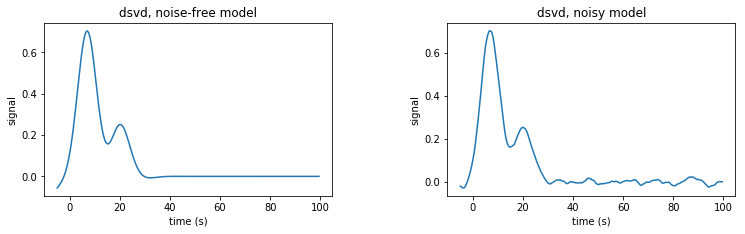

In [70]:
#### part f
# Dampened SVD 
sp2  = sp**2

a =   np.arange(0, 10, 0.1)
an = a.shape[0]

for i in range(a):
    a2    = a[i]**2
    Fd1  = (sp2/(sp2+a2))
    Fd2  = np.eye(p,p)
    Fd   = Fd2*Fd1
    Gt_dsvd      = np.dot(np.dot(vp,np.dot(Fd,smi)), up.T)
    mest_nf_dsvd = np.dot(Gt_dsvd, dnf)
    mest_n_dsvd  = np.dot(Gt_dsvd, dn)

# plot
ax=plt.subplot(121)
plt.subplots_adjust(left=0.4, bottom=0.4, right=2, top=1.0, hspace=0.4, wspace=0.4)
plt.plot(t,mest_nf_dsvd)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
plt.title('dsvd, noise-free model')

ax=plt.subplot(122)
plt.plot(t,mest_n_dsvd)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
plt.title('dsvd, noisy model')
plt.show()

(100,)


In [ ]:
g0  = np.exp(1)/ts

g = np.zeros(n)
for i in range(n):
    if i >= idx:
        ti = t[i]
        g[i] = g0*ti*np.exp(-ti/ts)
                
ax=plt.subplot(111)
plt.tick_params(axis="True", which="both", bottom="True", top="False", 
               labelbottom="True", left="True", right="False", labelleft="True")
plt.plot(t,g)
ax.set_xlabel("time (s)")
ax.set_ylabel("g")
plt.title('impulse response function')
plt.show()